# Pacotes

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from scipy.stats import mannwhitneyu, chi2_contingency, norm, kruskal

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

## Funções

In [2]:
def missing_values_table(df):
    """
    Cria uma tabela resumindo a quantidade e a porcentagem de valores ausentes em cada coluna do DataFrame.

    Args:
    df (pd.DataFrame): DataFrame para análise de valores ausentes.

    Etapas:
    1. Calcular a quantidade total de valores ausentes por coluna.
    2. Calcular a porcentagem de valores ausentes em relação ao total de linhas.
    3. Concatenar as duas métricas em um novo DataFrame.
    4. Renomear as colunas do DataFrame resultante para maior clareza.
    5. Filtrar e ordenar o DataFrame para mostrar apenas colunas com valores ausentes, em ordem decrescente de porcentagem.
    6. Imprimir um resumo sobre a presença de valores ausentes no DataFrame.

    Returns:
    pd.DataFrame: Uma tabela com o número e a porcentagem de valores ausentes por coluna.
    """
    # Calculando o número total de valores ausentes por coluna.
    mis_val = df.isnull().sum()
    
    # Calculando a porcentagem de valores ausentes.
    mis_val_percent = 100 * mis_val / len(df)
    
    # Criando um DataFrame com o número e a porcentagem de valores ausentes.
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renomeando as colunas do DataFrame para clareza.
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Filtrando o DataFrame para mostrar apenas colunas com valores ausentes e ordenando-as.
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # Imprimindo um resumo das colunas com valores ausentes.
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    
    return mis_val_table_ren_columns

## Config Básicas de gráficos

In [3]:
dic = {
    'font.sans-serif': ['Arial'],  # Fonte
    'font.family': ['Arial']}
sns.set_style(rc=dic)
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

## Dataset

In [4]:
# Carregar os dados
df1 = pd.read_csv('motorins.dat', sep='\t')

## Tratamento dos dados

In [5]:
# Tratando nome das colunas
df1.columns = ['Kilometers', 'Zone', 'Bonus', 'Make', 'Insured', 'Claims', 'Payment']

# Mapear a coluna Zone para categorias
zone_map = {
    1: 'Stockholm, Göteborg, Malmö with surroundings',
    2: 'Other large cities with surroundings',
    3: 'Smaller cities with surroundings in southern Sweden',
    4: 'Rural areas in southern Sweden',
    5: 'Smaller cities with surroundings in northern Sweden',
    6: 'Rural areas in northern Sweden',
    7: 'Gotland'
}
df1['Zone'] = df1['Zone'].map(zone_map)
#df1['Zone'] = df1['Zone'].astype('category')

# Mapear a coluna Make para categorias
make_map = {
    1: 'modelo 1',
    2: 'modelo 2',
    3: 'modelo 3',
    4: 'modelo 4',
    5: 'modelo 5',
    6: 'modelo 6',
    7: 'modelo 7',
    8: 'modelo 8',
    9: 'Outros'
}
df1['Make'] = df1['Make'].map(make_map)
#df1['Make'] = df1['Make'].astype('category')

# Mapear a coluna Kilometres para categorias
kilometres_map = {
    1: 'less than 1000',
    2: 'from 1000 to 15000',
    3: '15000 to 20000',
    4: '20000 to 25000',
    5: 'more than 25000'
}
df1['Kilometers'] = df1['Kilometers'].map(kilometres_map)
#df1['Kilometers'] = df1['Kilometers'].astype('category')

In [6]:
## Teste de chi-quadrado

## Informações sobre o dataset

In [7]:
df1.head()

,Kilometers,Zone,Bonus,Make,Insured,Claims,Payment
0,less than 1000,"Stockholm, Göteborg, Malmö with surroundings",1,modelo 1,455.13,108,392491
1,less than 1000,"Stockholm, Göteborg, Malmö with surroundings",1,modelo 2,69.17,19,46221
2,less than 1000,"Stockholm, Göteborg, Malmö with surroundings",1,modelo 3,72.88,13,15694
3,less than 1000,"Stockholm, Göteborg, Malmö with surroundings",1,modelo 4,1292.39,124,422201
4,less than 1000,"Stockholm, Göteborg, Malmö with surroundings",1,modelo 5,191.01,40,119373


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Kilometers  2182 non-null   object 
 1   Zone        2182 non-null   object 
 2   Bonus       2182 non-null   int64  
 3   Make        2182 non-null   object 
 4   Insured     2182 non-null   float64
 5   Claims      2182 non-null   int64  
 6   Payment     2182 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 119.5+ KB


In [9]:
df1.describe()

,Bonus,Insured,Claims,Payment
count,2182.000000,2182.000000,2182.000000,2.182000e+03
mean,4.015124,1092.195270,51.865720,2.570076e+05
std,2.000516,5661.156245,201.710694,1.017283e+06
min,1.000000,0.010000,0.000000,0.000000e+00
25%,2.000000,21.610000,1.000000,2.988750e+03
50%,4.000000,81.525000,5.000000,2.740350e+04
75%,6.000000,389.782500,21.000000,1.119538e+05
max,7.000000,127687.270000,3338.000000,1.824503e+07


## Dados missing

In [10]:
missing_values_table(df1)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Countplot

### Kilometers

([0, 1, 2, 3, 4],
 [Text(0, 0, 'less than 1000'),
  Text(1, 0, 'from 1000 to 15000'),
  Text(2, 0, '15000 to 20000'),
  Text(3, 0, '20000 to 25000'),
  Text(4, 0, 'more than 25000')])

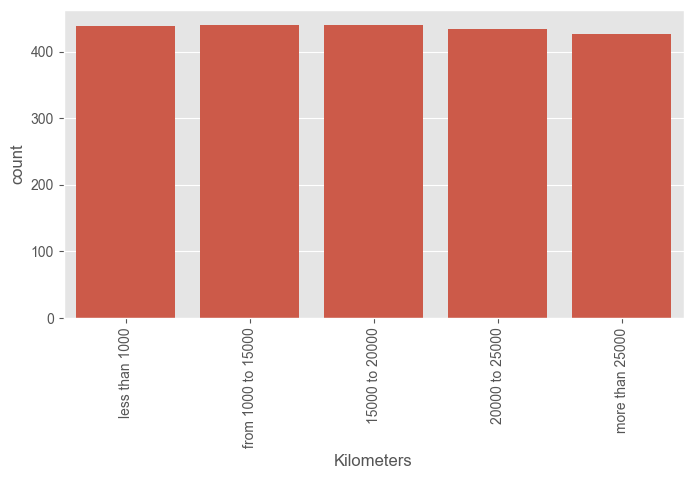

In [11]:
# Verificar outliers nas variáveis preditoras
plt.figure(figsize=(8, 4))
sns.countplot(data=df1, x='Kilometers')
plt.xticks(rotation=90)

### Zone

In [31]:
df1.Zone.value_counts()

Zone
Stockholm, Göteborg, Malmö with surroundings           315
Other large cities with surroundings                   315
Smaller cities with surroundings in southern Sweden    315
Rural areas in southern Sweden                         315
Rural areas in northern Sweden                         315
Smaller cities with surroundings in northern Sweden    313
Gotland                                                294
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Stockholm, Göteborg, Malmö with surroundings'),
  Text(1, 0, 'Other large cities with surroundings'),
  Text(2, 0, 'Smaller cities with surroundings in southern Sweden'),
  Text(3, 0, 'Rural areas in southern Sweden'),
  Text(4, 0, 'Smaller cities with surroundings in northern Sweden'),
  Text(5, 0, 'Rural areas in northern Sweden'),
  Text(6, 0, 'Gotland')])

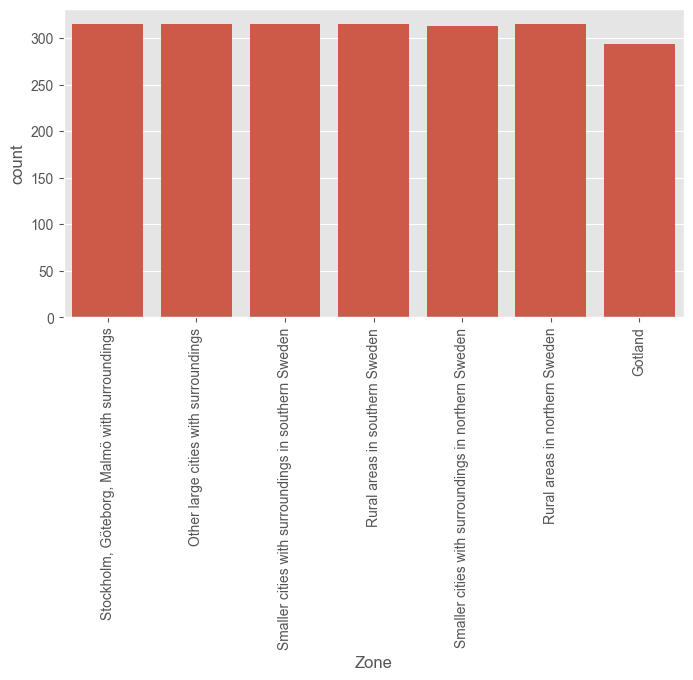

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df1, x='Zone')
plt.xticks(rotation=90)

### Make

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'modelo 1'),
  Text(1, 0, 'modelo 2'),
  Text(2, 0, 'modelo 3'),
  Text(3, 0, 'modelo 4'),
  Text(4, 0, 'modelo 5'),
  Text(5, 0, 'modelo 6'),
  Text(6, 0, 'modelo 7'),
  Text(7, 0, 'modelo 8'),
  Text(8, 0, 'Outros')])

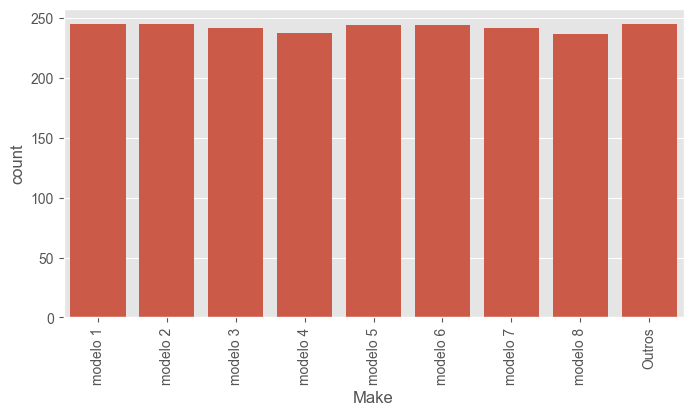

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df1, x='Make')
plt.xticks(rotation=90)

## Boxplot 

### Bonus

<Axes: ylabel='Bonus'>

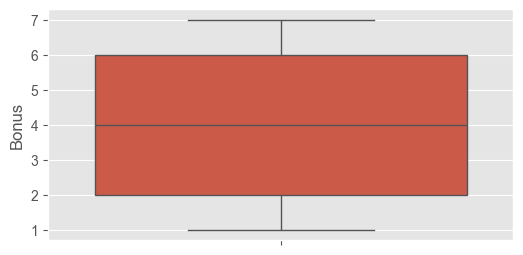

In [14]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df1, y='Bonus')

### Insured

<Axes: ylabel='Insured'>

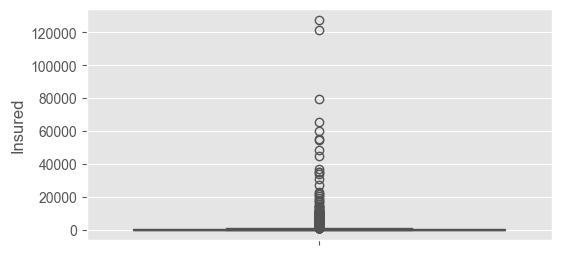

In [15]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df1, y='Insured')

### PairPlot

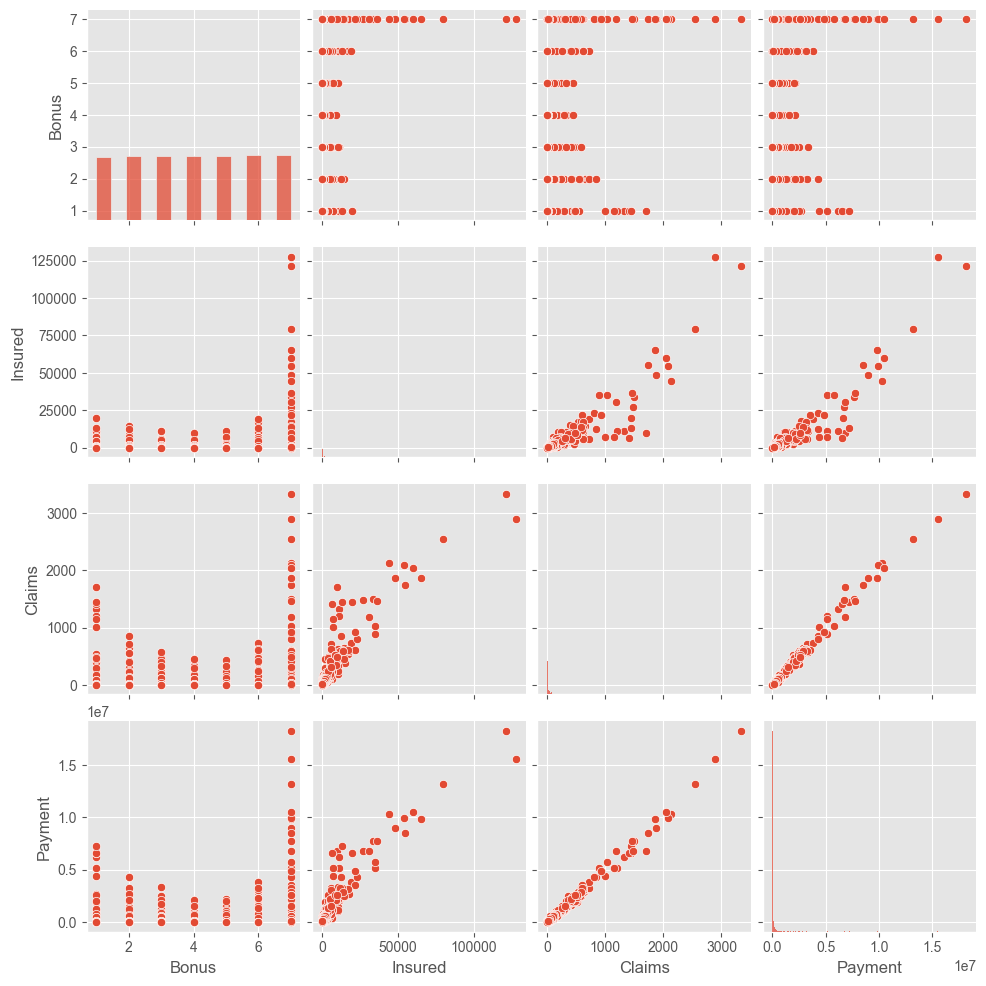

In [16]:
# Selecionar apenas colunas numéricas para a correlação
colunas_numericas = df1.select_dtypes(include=['float64', 'int64'])
sns.pairplot(colunas_numericas)

## Teste de shapiro-wilk para vericar normalidade 

In [24]:
# Teste de normalidade de Shapiro-Wilk
shapiro_test = stats.shapiro(df1.Claims)
print(f"Shapiro-Wilk normality test: W={shapiro_test[0]}, p-value={shapiro_test[1]}")

Shapiro-Wilk normality test: W=0.24694865942001343, p-value=0.0


## Testes de hipotese 

### Correlação de spearman

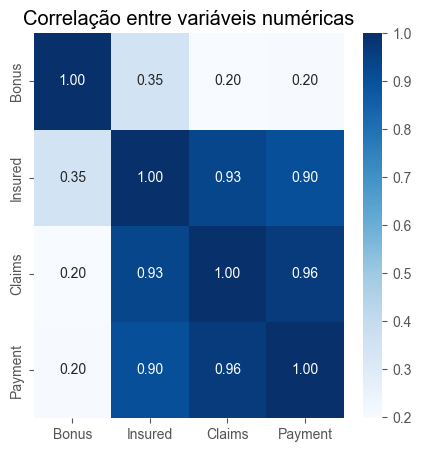

In [17]:
# Selecionar apenas colunas numéricas para a correlação
colunas_numericas = df1.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação apenas com as colunas numéricas
corr = colunas_numericas.corr('spearman')

# Criar um heatmap com a matriz de correlação
plt.rcParams['figure.figsize'] = [5, 5]
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlação entre variáveis numéricas')
plt.show()

### Teste de Kruskal-Wallis

In [18]:
# Teste de Kruskal-Wallis para variáveis categóricas
kw_kilometers = kruskal(*[df1[df1['Kilometers'] == cat]['Claims'] for cat in df1['Kilometers'].unique()])
kw_zone = kruskal(*[df1[df1['Zone'] == cat]['Claims'] for cat in df1['Zone'].unique()])
kw_make = kruskal(*[df1[df1['Make'] == cat]['Claims'] for cat in df1['Make'].unique()])

print(f"Teste de Kruskal-Wallis para Kilometers: {kw_kilometers}")
print(f"Teste de Kruskal-Wallis para Zone: {kw_zone}")
print(f"Teste de Kruskal-Wallis para Make: {kw_make}")

Teste de Kruskal-Wallis para Kilometers: KruskalResult(statistic=195.72553167450306, pvalue=3.117263894895815e-41)
Teste de Kruskal-Wallis para Zone: KruskalResult(statistic=542.9041459870552, pvalue=4.7798986253134086e-114)
Teste de Kruskal-Wallis para Make: KruskalResult(statistic=691.6308951948237, pvalue=4.5332978426564537e-144)


### Teste Mann-Whitney U

In [19]:
# Lista de variáveis numéricas
numerical_vars = ['Bonus', 'Insured']

# Resultados do teste Mann-Whitney U
mannwhitney_results = {}
significant_vars_mannwhitney = []

# Nível de significância
alpha = 0.05

for var in numerical_vars:
    group1 = df1[df1['Claims'] == 0][var]
    group2 = df1[df1['Claims'] > 0][var]
    stat, p = mannwhitneyu(group1, group2)
    mannwhitney_results[var] = p
    if p < alpha:
        significant_vars_mannwhitney.append(var)

# Imprimir resultados significativos
print("Variáveis numéricas com resultados significativos no teste Mann-Whitney U:")
for var in significant_vars_mannwhitney:
    print(f"{var}: p-valor = {mannwhitney_results[var]}")

Variáveis numéricas com resultados significativos no teste Mann-Whitney U:
Bonus: p-valor = 1.4647389332811162e-05
Insured: p-valor = 9.184641280479907e-170


### Teste de qui-quadrado para variáveis categóricas

In [20]:
# Lista de variáveis categóricas
categorical_vars = ['Kilometers', 'Zone', 'Make']

# Resultados do teste de qui-quadrado
chi2_results = {}
significant_vars_chi2 = []

# Nível de significância
alpha = 0.05

for var in categorical_vars:
    contingency_table = pd.crosstab(df1[var], df1['Claims'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[var] = p
    if p < alpha:
        significant_vars_chi2.append(var)

# Imprimir resultados significativos
print("Variáveis categóricas com resultados significativos no teste de qui-quadrado:")
for var in significant_vars_chi2:
    print(f"{var}: p-valor = {chi2_results[var]}")

Variáveis categóricas com resultados significativos no teste de qui-quadrado:
Kilometers: p-valor = 0.0011081654037870712
Zone: p-valor = 2.1050504276507513e-24
Make: p-valor = 7.774440399334877e-14


## Ajuste de Possoin

### Pacote Statmodels

In [63]:
# Normalizar variáveis numéricas
scaler = StandardScaler()
df1[['Bonus']] = scaler.fit_transform(df1[['Bonus']])

# Ajustar o modelo de Poisson com offset
model = smf.poisson('Claims ~ Kilometers + Zone + Bonus + Make', data=df1).fit(offset=np.log(df1['Insured']))

# Resumo do modelo
print(model.summary())

Optimization terminated successfully.
         Current function value: 15.980153
         Iterations 12
                          Poisson Regression Results                          
Dep. Variable:                 Claims   No. Observations:                 2182
Model:                        Poisson   Df Residuals:                     2162
Method:                           MLE   Df Model:                           19
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.8426
Time:                        18:28:18   Log-Likelihood:                -34869.
converged:                       True   LL-Null:                   -2.2157e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercep

C:\Users\pedro\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: offset. After release 0.14, this will raise.
  warnings.warn(


In [72]:
print(model)

#### Análise dos Resíduos

In [26]:
# Previsões do modelo
y_pred_statsmodels = model.fittedvalues

# Calcular resíduos
residuos_statsmodels = df1['Claims'] - y_pred_statsmodels

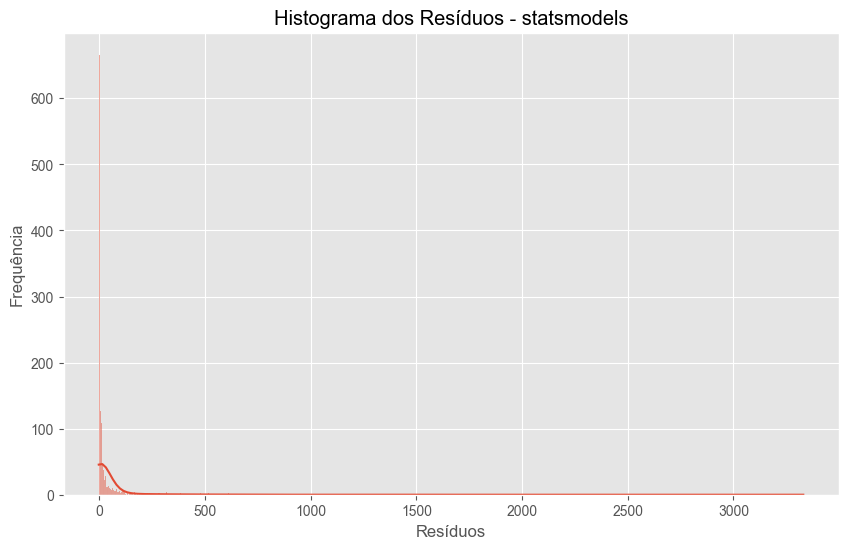

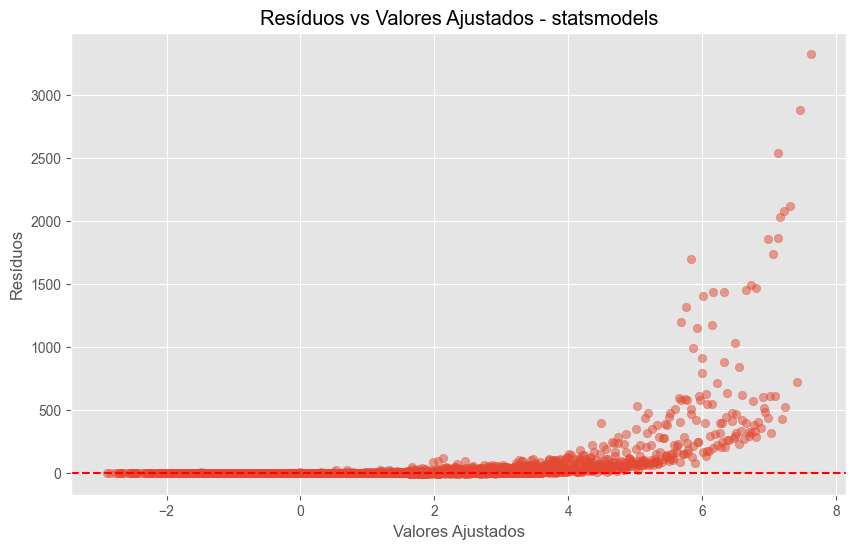

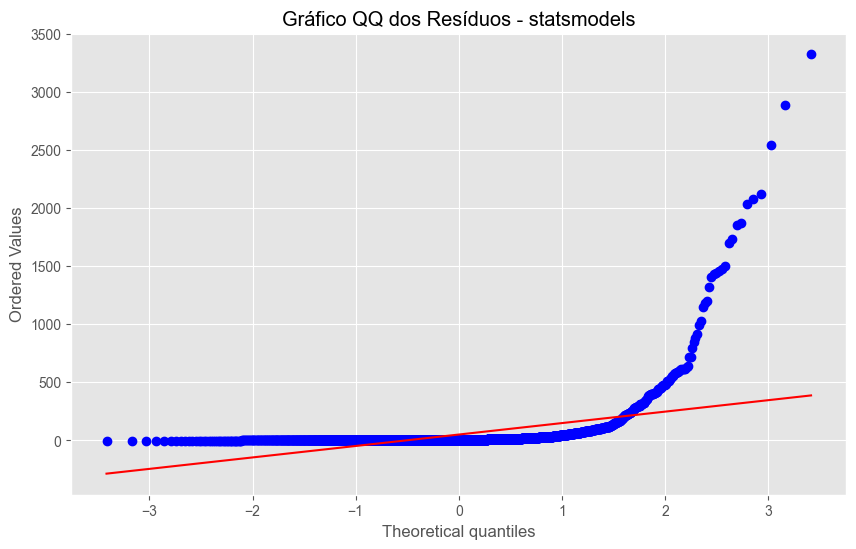

In [27]:
# Histograma dos resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuos_statsmodels, kde=True)
plt.title('Histograma dos Resíduos - statsmodels')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Gráfico de dispersão dos resíduos versus valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_statsmodels, residuos_statsmodels, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Ajustados - statsmodels')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

# Gráfico QQ
plt.figure(figsize=(10, 6))
stats.probplot(residuos_statsmodels, dist="norm", plot=plt)
plt.title('Gráfico QQ dos Resíduos - statsmodels')
plt.show()